# MNIST Digit Classifier with PyTorch

This notebook walks through training a simple neural network to recognize handwritten digits (0–9) using the MNIST dataset.  
It uses PyTorch for model definition and training, and evaluates accuracy after 5 training epochs.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


## Step 1: Set Device (CPU or GPU)

Check if a GPU is available and use it — this speeds up training if supported. Otherwise, default to the CPU.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Step 2: Load and Preprocess the MNIST Dataset

We load the MNIST dataset of 28x28 grayscale digit images.  
Each image is transformed into a tensor and normalized to improve learning.


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean and std dev for MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

## Step 3: Define the Neural Network

This is a fully connected neural network with:
- Two hidden layers (128 and 64 neurons)
- ReLU activations
- An output layer for 10 digit classes (0–9)
- Log-Softmax to produce probability-like outputs


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


## Step 4: Train the Model

We train the model for 5 epochs using the Adam optimizer and negative log likelihood loss.  
Each batch of images is passed through the model, the error is calculated, and the weights are updated.


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch}: Average Loss = {avg_loss:.4f}")

Epoch 1: Average Loss = 0.2705
Epoch 2: Average Loss = 0.1135
Epoch 3: Average Loss = 0.0784
Epoch 4: Average Loss = 0.0617
Epoch 5: Average Loss = 0.0489


## Step 5: Evaluate the Model

We evaluate the trained model on the test dataset.  
This gives us the overall accuracy — the percentage of digits the model correctly classifies.


In [15]:
model.eval()  # set to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # disable gradient tracking for faster inference
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the highest log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

accuracy = 100. * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 97.53%


## Step 6: Save the Trained Model

Save the trained model's weights to a file so it can be reloaded later without retraining.


In [16]:
torch.save(model.state_dict(), "mnist_model.pth")
print("Model saved to mnist_model.pth")


Model saved to mnist_model.pth



## Step 7: Visualize Model Predictions

Display a few test images alongside the model's predicted labels to assess performance visually.


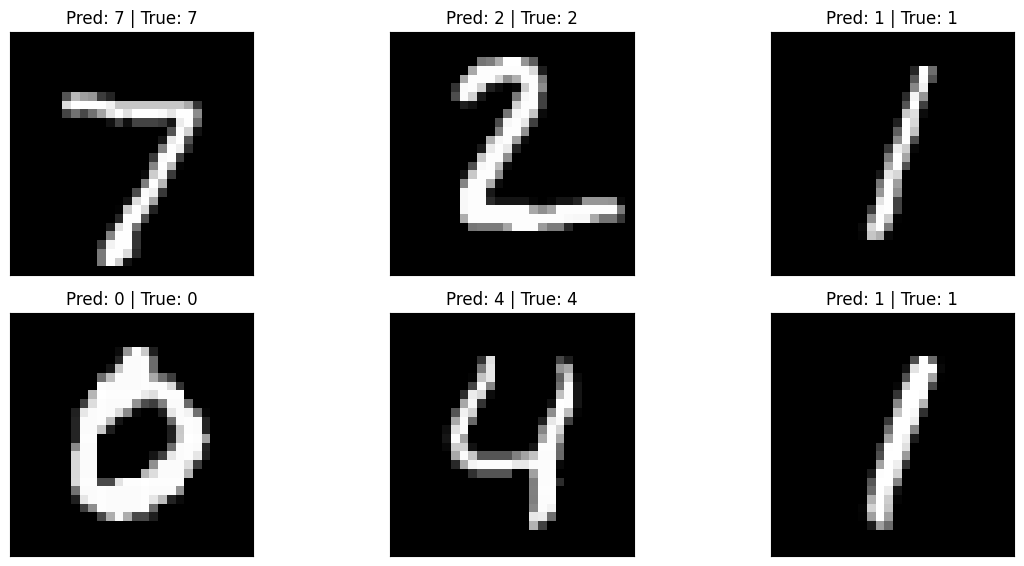

In [18]:
import matplotlib.pyplot as plt

model.eval()
test_examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(test_examples)

with torch.no_grad():
    example_data = example_data.to(device)
    output = model(example_data)

fig = plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0].cpu(), cmap='gray', interpolation='none')
    pred_label = output[i].argmax(dim=0, keepdim=True).item()
    true_label = example_targets[i].item()
    plt.title(f"Pred: {pred_label} | True: {true_label}")
    plt.xticks([])
    plt.yticks([])
plt.show()


## Step 8: Visualize Misclassified Digits

Let’s look at a few test images the model predicted incorrectly.


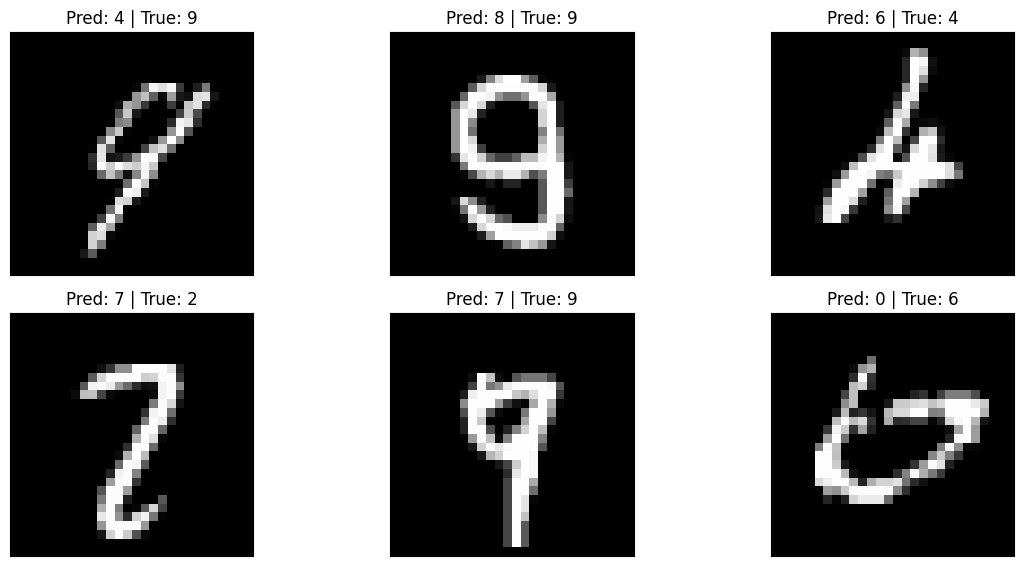

In [ ]:
model.eval()  # set to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # disable gradient tracking for faster inference
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the highest log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

accuracy = 100. * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")



## Step 9: Confusion Matrix

See where the model tends to make mistakes by visualizing a confusion matrix.


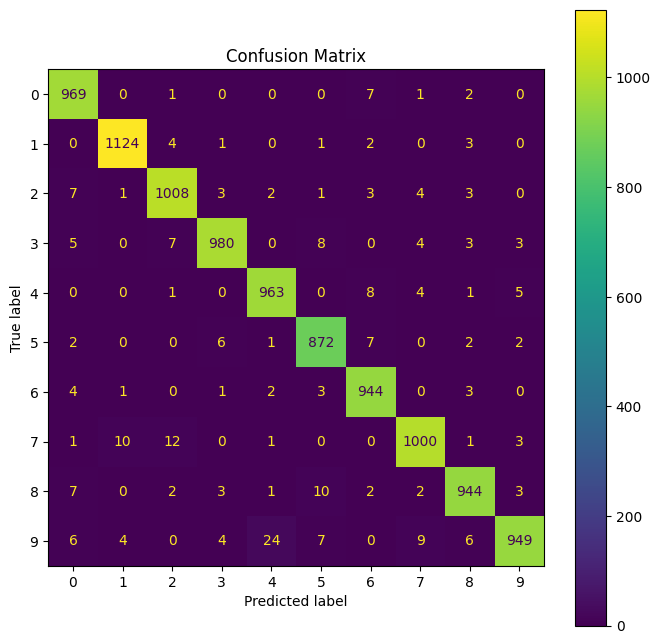

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Gather all predictions
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        output = model(data)
        pred = output.argmax(dim=1).cpu()
        all_preds.extend(pred)
        all_targets.extend(target)

# Generate and display confusion matrix
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
plt.title("Confusion Matrix")
plt.show()
